# Lesson 3: Building an Agent Reasoning Loop

Last amended: 22th March, 2025   
Ref: [deeplearning.ai](https://learn.deeplearning.ai/courses/building-agentic-rag-with-llamaindex/lesson/ix5w5/building-an-agent-reasoning-loop)     
Login with email: ashok@fsm.ac.in (password is the usual one)    
   
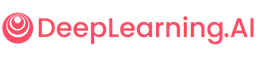


## llamaIndex examples on github

See this llamaindex site for [AgentWorkFlow](https://www.llamaindex.ai/blog/introducing-agentworkflow-a-powerful-system-for-building-ai-agent-systems)      

Also see [this blog](https://www.llamaindex.ai/blog/introducing-agentworkflow-a-powerful-system-for-building-ai-agent-systems) by llamaIndex on AgentWorkflow

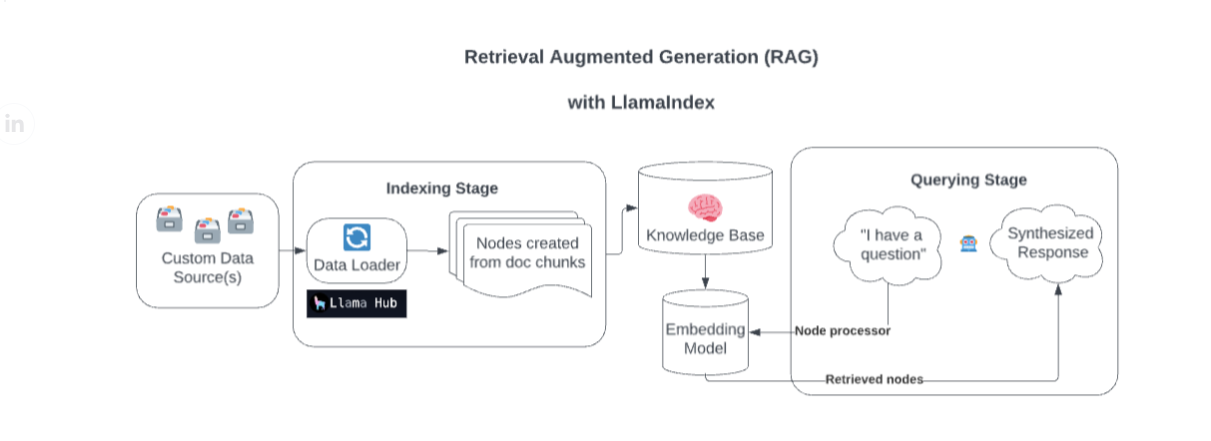

## Setup

In [62]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
# 1.0
import nest_asyncio
nest_asyncio.apply()

## Load the data

To download this paper, below is the needed code:

#!wget "https://openreview.net/pdf?id=VtmBAGCN7o" -O metagpt.pdf

**Note**: The pdf file is included with this lesson. To access it, go to the `File` menu and select`Open...`.

In [64]:
# 1.0
import nest_asyncio
nest_asyncio.apply()

In [2]:
# 2.0

from llama_index.core import Settings
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.llms.openai_like import OpenAILike


# 2.1
"""
# Quick but output is NOT that good.
Settings.llm = Ollama(
                                     model="llama3.2:latest",
                                     request_timeout=120.0,
                                     temperature = 0.4,
                                     mirostat = 0)

"""

# Takes a lot of time but the output is better
Settings.llm = OpenAILike(
                          temperature=0.7,
                          model= "llama-3.2-3b-instruct:q8_0",   # "gpt-3.5-turbo",  # "gemma-3-27b-it",  #          # Can be any name, not necessarily openai's gpt
                          api_base="http://127.0.0.1:8080/v1",
                          api_key="fake",
                          timeout= 1000.0,
                          is_chat_model = True,
                          is_function_calling_model=True,
                          )

# 2.2
Settings.embed_model = OllamaEmbedding(
                                        model_name="nomic-embed-text",      # Using foundational model may be overkill
                                        base_url="http://localhost:11434",
                                       )


/home/ashok/langchain/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# 3.0

from llama_index.core import SimpleDirectoryReader

# 3.1 load documents
# documents = SimpleDirectoryReader(input_files=["/home/ashok/Documents/csvrag/metagpt.pdf"]).load_data()
documents = SimpleDirectoryReader(input_files=["/home/ashok/Documents/csvrag/programobjectives.pdf"]).load_data()

In [7]:
# 4.0

from llama_index.core.node_parser import SentenceSplitter

# 3.1
splitter = SentenceSplitter(chunk_size=1024)

# 3.2
nodes = splitter.get_nodes_from_documents(documents)

## Setup the Query Tools

In [8]:
# 5.0
from llama_index.core import SummaryIndex, VectorStoreIndex

# 5.0
summary_index = SummaryIndex(nodes)

# 5.1
vector_index = VectorStoreIndex(
                                 nodes,
                                 show_progres = True
                               )

### ToDo: Try chat engine instead of `as_query_engine()`
See [here](https://docs.llamaindex.ai/en/stable/module_guides/deploying/chat_engines/)     
Check whether chat method is possible

In [9]:
# 6.0
summary_query_engine = summary_index.as_query_engine(
                                                     response_mode="tree_summarize",
                                                     use_async=True,  # Optional but gives faster response
                                                     streaming=True,
                                                    )

# 6.1
vector_query_engine = vector_index.as_query_engine(
                                                    show_progress = True,
                                                    use_async = True ,
                                                    streaming=True,
                                                      )

In [70]:
# --- Other query engines

In [10]:
# 7.0

from llama_index.core.tools import QueryEngineTool

# 7.1
summary_tool = QueryEngineTool.from_defaults(
                                             query_engine=summary_query_engine,
                                             description=(
                                                          "Useful for summarization questions related to MetaGPT"
                                                          ),
                                              )

# 7.2
vector_tool = QueryEngineTool.from_defaults(
                                             query_engine=vector_query_engine,
                                             description=(
                                                           "Useful for retrieving specific context from the programobjectives paper."
                                                         ),
                                            )

# 7.3
#  ---- Other tools


In [25]:
#from utils import get_doc_tools

#vector_tool, summary_tool = get_doc_tools("metagpt.pdf", "metagpt")

## Setup Function Calling Agent

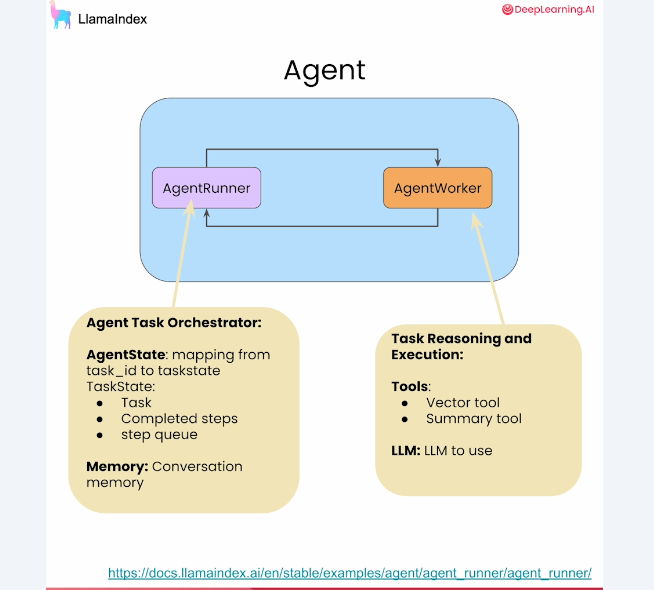

Another generic figure

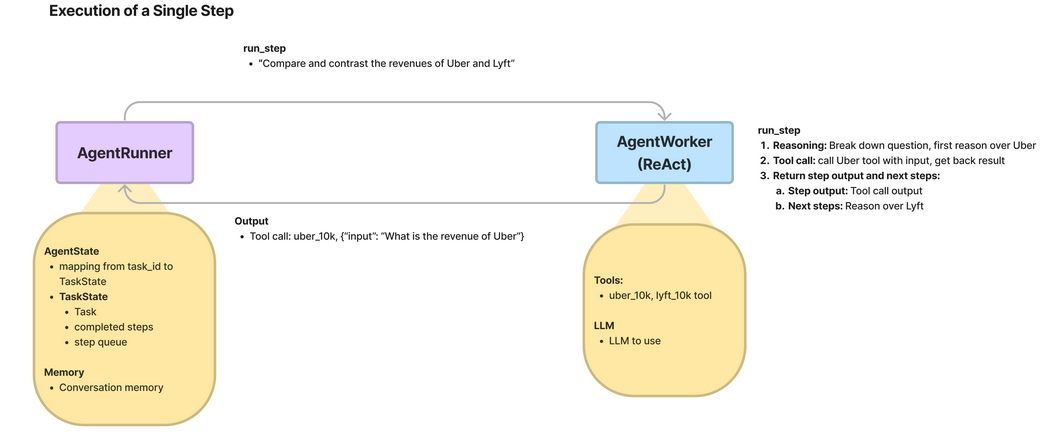

## What are Agent runner and Agent worker

In the context of LlamaIndex, an AgentRunner orchestrates the execution of tasks, managing state, and creating/running steps, while an AgentWorker controls the step-wise execution of a task, generating the next step based on the input and state. 
Here's a more detailed breakdown:

    AgentRunner:
        Orchestrator: The AgentRunner is the main orchestrator, responsible for managing the overall flow of an agent's execution.
        Task Management: It creates and maintains tasks, which are essentially high-level goals or queries provided by the user.
        State Management: It stores state (including conversational memory) and passes it to the AgentWorker.
        Step Execution: It calls the AgentWorker to execute steps within a task and collects/aggregates the results.
        User Interface: It provides the user-facing, high-level interface for users to interact with the agent. 
    AgentWorker:
        Step-wise Execution: The AgentWorker is responsible for controlling the step-wise execution of a task.
        Next Step Generation: It generates what the next step should be based on the input and the current state of the task.
        Task Execution: It takes a task and executes the steps within it, potentially using tools or other resources.
        Result Collection: It returns the output of each step to the AgentRunner. 

In essence: The AgentRunner acts as the conductor, while the AgentWorker is the musician, executing the steps in the task according to the AgentRunner's direction.

In [11]:
# 8.0
llm = Settings.llm

In [12]:
# 9.0

from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

# 9.1 Define workers
agent_worker = FunctionCallingAgentWorker.from_tools(
                                                      [vector_tool, summary_tool], 
                                                      llm=llm, 
                                                      verbose= True  # Try also False
                                                    )

# 9.2 Define supervisor
agent = AgentRunner(agent_worker)

In [13]:
%%time

# 10.0  Query the supervisor:
response = agent.query(
                      "Summarise the document and then tell me are progarm objectives met"
                      )

Added user message to memory: Summarise the document and then tell me are progarm objectives met
=== Calling Function ===
Calling function: query_engine_tool with args: {"input": "Summarise the document and then tell me are program objectives met"}
=== Function Output ===
**Summary:**
The document outlines the objectives and structure of a program in data analytics, big data, and artificial intelligence. The program is designed to equip participants with skills in machine learning algorithms, Hadoop and Kafka ecosystems, NoSQL databases, deep learning, and generative AI. The program is project-based and covers a range of topics, including data cleaning, transformation, feature engineering, predictive analytics, and data visualization. The program aims to provide a comprehensive understanding of big data technologies and their applications across various industries.

**Are Program Objectives Met?**

Based on the provided information, the program objectives appear to be well-defined and 

In [ ]:
# You can also set up a loop to constantly query:

while True:
    text_input = input("User: ")
    if text_input == "exit":
        break
    response = agent.chat(text_input)
    print(f"Agent: {response}")

### Output from the above command
Took 9.5 minutes on my machine

Added user message to memory: Summarise the document and then tell me are progarm objectives met
=== Calling Function ===
Calling function: query_engine_tool with args: {"input": "Please provide the document you want me to summarize and the program objectives so I can summarize and tell you if they are met."}
=== Function Output ===
The document to be summarized is a PDF titled "Program Objectives" with five page labels (/home/ashok/Documents/csvrag/programobjectives.pdf).

The program objectives are divided into three main segments: Analytics, Technological, and Generative AI and Designing LLM products. The Analytics segment covers Machine Learning Algorithms, Hadoop and Kafka ecosystem, NoSQL and Graph databases, and Deep Learning and AI. The Technological segment covers learning to use Spark on Hadoop/NoSQL databases and work on Streaming Data Analytics using Apache Kafka. The Generative AI and Designing LLM products segment covers Text Generation, Creative Applications, Conversational AI, Analytical Applications, Educational Applications, and Research and Development.

The course is designed to equip participants with skills in data analysis, machine learning, and deep learning, and is suitable for various professionals including executives, data scientists, academics, lecturers, healthcare professionals, students, and researchers. The course objectives include:

* Cleaning, transforming, and visualizing a dataset to gain deeper insights and make it ready for further analysis
* Engineering features and selecting a subset of machine learning or deep learning algorithms for predictive results
* Making situation and context-specific performance assessment and interpreting predictive models
* Applying knowledge of image processing, image analysis, sensor-data analysis, and language modeling to various disciplines
* Designing and creating knowledge-products using Large Language Models
* Installing, setting up, and configuring Hadoop and Kafka ecosystems, NoSQL databases, deep learning platforms, and Web-User Interfaces
* Executing projects on Kaggle, creating a GitHub repository, and hosting LLM-based web-interfaces on HuggingFace

The course is project-oriented, and participants receive Virtual Machines (VMs) fully equipped with software platforms, tools, packages, and data to work on. The course is designed to be practice-based, with constant interaction with the teacher during lecture hours in real-time.
=== Calling Function ===
Calling function: query_engine_tool with args: {"approach?": "}", "{\"input\":": "What does the program objectives document say about the course design"}
=== Function Output ===
The program objectives document emphasizes a practice-based approach rather than a theory-based approach. The teaching pedagogy involves conceptually explaining algorithms and then having students implement the techniques through projects. Datasets and code are made available in advance, and students execute the code on their laptops, with the teacher and students working simultaneously. The approach is designed to be collaborative and interactive, with an emphasis on creative problem-solving and exploration.
=== Calling Function ===
Calling function: query_engine_tool with args: {"{\"input\":": "What are the program objectives met?"}
=== Function Output ===
The program objectives are to:

1. Clean, transform, and visualize a dataset to gain deeper insights and make it ready for further analysis.
2. Engineer features and select a subset of appropriate machine learning or deep learning algorithms to get desired predictive results.
3. Make situation and context-specific performance assessment, interpret predictive models, and explain them to clients.
4. Apply knowledge of image processing, image analysis, sensor-data analysis, and language modeling to a wide range of disciplines.
5. Design/create knowledge-products using Large Language Models.
6. Install, setup, and configure a complete Hadoop and Kafka ecosystem (including Hive, Spark, Zookeeper, Flume, and other important layers).
7. Install, configure, and be familiar with a variety of NoSQL databases and decide which one to use, when, and how.
8. Install fully functional various deep learning platforms including Tensorflow and PyTorch.
9. Install a Web-User Interface(s) incorporating RAG for managing LLMs.
10. Engage in projects that utilize tools, data, and platforms including deep-learning platforms, Hadoop-ecosystem, Kafka-streaming technologies, and LLMs, with a focus on open-source technologies.
=== Calling Function ===
Calling function: query_engine_tool with args: {"{\"input\":": "Are the program objectives met?"}
=== Function Output ===
The program objectives appear to be met for the following reasons:

1. The program covers a wide range of applications of Big Data and AI, including marketing, sales, sports, molecular biology, drug-designing, waste management, finance, healthcare, knowledge products, and smart cities.
2. The program provides a comprehensive curriculum that includes Machine Learning Algorithms, Hadoop and Kafka ecosystem, NoSQL and Graph databases, and Generative AI.
3. The program is project-based, which aligns with the goal of generating familiarity with Big Data, Data Visualization, and Data Mining algorithms, and developing skills to set up predictive models with disparate datasets.
4. The program covers various industries and applications, including healthcare, finance, and education, which aligns with the objective of exposing students to novel ways of applying Big Data technologies among shifting business models.
5. The program provides opportunities for students to work on real-world projects, including Kaggle and GitHub, which aligns with the objective of developing skills to set up predictive models with disparate datasets.

Overall, the program objectives appear to be well-rounded and comprehensive, covering a wide range of topics and applications, and providing opportunities for hands-on learning and project-based learning.
=== LLM Response ===
No, the program objectives are not fully met, as the document mentions that the course is designed to be project-based, with constant interaction with the teacher during lecture hours in real-time, but does not explicitly state that the course covers all of the objectives mentioned.
CPU times: user 84.5 ms, sys: 59 ms, total: 144 ms
Wall time: 9min 37s

In [14]:
# 10.1
print(response.source_nodes[0].get_content(metadata_mode="all"))

page_label: 1
file_name: programobjectives.pdf
file_path: /home/ashok/Documents/csvrag/programobjectives.pdf
file_type: application/pdf
file_size: 94622
creation_date: 2025-03-22
last_modified_date: 2025-03-22

Program Objectives  
Applications of Big Data & AI transcend Industries. Use of predictive analytics pervades 
diverse disciplines such as marketing and sales, sports, molecular biology, drug-
designing, waste management, finance, healthcare, knowledge products and the list is 
very long. Smart cities, for example, are the melting pot where variety of big data 
technologies mesh with one another to transform a city into a semi-intelligent being. In 
Marketing and Sales, for example, Big Data & AI are fast emerging as a potent tool to 
gain deeper insights into Customer behavior and thereby act as a strong driver in 
spurring innovation. In manufacturing, operations managers are employing advanced 
analytics on historical process data to identify patterns and relationships among 

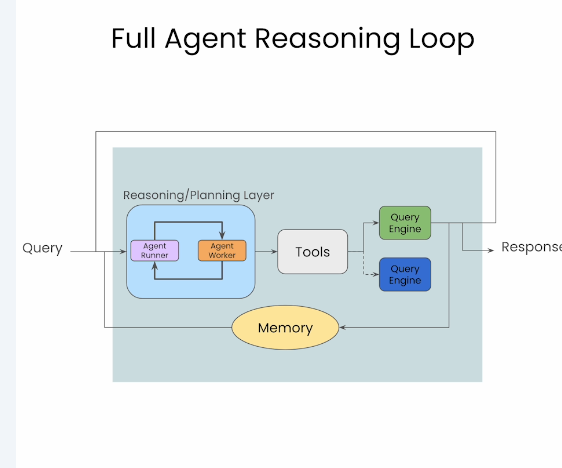

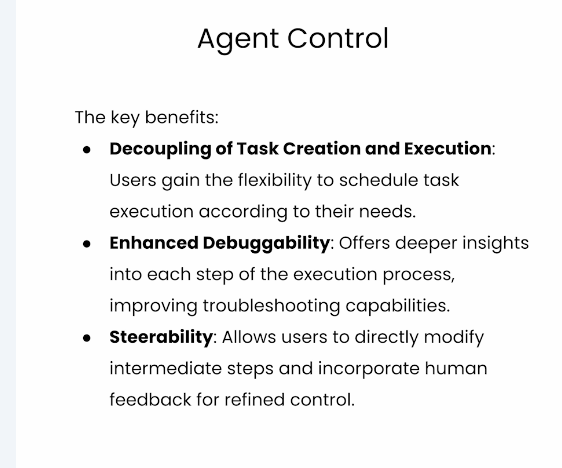

In [ ]:
#10.2

response = agent.chat(
                       "Tell me about the evaluation datasets used."
                     )

In [ ]:
# 10.3

response = agent.chat("Tell me the results over one of the above datasets.")

## Lower-Level: Debuggability and Control

In [ ]:
agent_worker = FunctionCallingAgentWorker.from_tools(
                                                      [vector_tool, summary_tool], 
                                                       llm=llm, 
                                                       verbose=True
                                                    )

agent = AgentRunner(agent_worker)

In [ ]:

task = agent.create_task(
                         "Tell me about the agent roles in MetaGPT, "
                         "and then how they communicate with each other."
                        )

In [ ]:
step_output = agent.run_step(task.task_id)

In [ ]:
completed_steps = agent.get_completed_steps(task.task_id)

print(f"Num completed for task {task.task_id}: {len(completed_steps)}")
print(completed_steps[0].output.sources[0].raw_output)

In [ ]:
upcoming_steps = agent.get_upcoming_steps(task.task_id)

print(f"Num upcoming steps for task {task.task_id}: {len(upcoming_steps)}")
upcoming_steps[0]

In [ ]:
step_output = agent.run_step(
                              task.task_id, input="What about how agents share information?"
                            )

In [ ]:
step_output = agent.run_step(task.task_id)
print(step_output.is_last)

In [ ]:
response = agent.finalize_response(task.task_id)

In [ ]:
print(str(response))